In [1]:
!pip install faiss-cpu
!pip install gdown
!pip install ftfy
!pip install matplotlib pillow numpy torch


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
from clip.model import convert_weights, CLIP
from clip.clip import tokenize
import torch
import json
task_weight = 'D:/AIC/models/tsbir_model_final.pt'
task_ar = 'D:/AIC/models/ViT-B-16.json'
#torch.cuda.set_device(device)
device='cuda' if torch.cuda.is_available() else 'cpu'
with open(task_ar, 'r', encoding='utf-8') as f:
    model_info = json.load(f)

TASK = CLIP(**model_info)

loc = "cuda:{}".format(device)
checkpoint = torch.load(task_weight, map_location=device)

sd = checkpoint["state_dict"]
if next(iter(sd.items()))[0].startswith('module'):
    sd = {k[len('module.'):]: v for k, v in sd.items()}

TASK.load_state_dict(sd, strict=False)

TASK.eval()
TASK.to(device)


d:\AIC\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [4]:
from clip.clip import _transform
convert_weights(TASK)
transformer = _transform(TASK.visual.input_resolution) # hàm để transform ảnh

In [7]:
import numpy as np
import faiss
import glob
from PIL import Image
# Tạo danh sách để lưu trữ các vector nhúng
image_dir = "./AIC_Data/AIC_Keyframes/Keyframes_L01/L01_V002"# đường dẫn đến file ảnh, thay đổi để làm tiếp file ảnh tiếp theo
image_files = glob.glob(image_dir + "/*.jpg")

embeddings = []
for image_path in image_files:
  # Tải keyframe và tiền xử lý
  image = transformer(Image.open(image_path)).unsqueeze(0).to(device)
  # Tạo nhúng cho keyframe
  with torch.no_grad():
    image_features = TASK.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
  
  # Chuyển nhúng thành vector numpy để dùng cho Faiss  
  image_features = image_features.cpu().numpy()

  # Thêm vector nhúng vào danh sách
  embeddings.append(image_features)

  # Chuyển danh sách nhúng thành mảng numpy để dễ dàng sử dụng với Faiss
embeddings = np.vstack(embeddings)
# lưu file numpy
#np.save("L07_V0011.npy", embeddings)


In [20]:
embeddings

array([[ 0.008194, -0.0694  ,  0.02003 , ...,  0.000711,  0.02734 ,
        -0.01735 ],
       [-0.02452 , -0.01037 , -0.07306 , ..., -0.01111 ,  0.063   ,
        -0.0522  ],
       [-0.03244 , -0.02354 , -0.05304 , ..., -0.0182  ,  0.04144 ,
        -0.05734 ],
       ...,
       [-0.0317  , -0.02618 , -0.05157 , ..., -0.02516 ,  0.03693 ,
        -0.07355 ],
       [-0.03262 , -0.04388 , -0.05814 , ..., -0.02301 ,  0.03986 ,
        -0.0672  ],
       [-0.01233 , -0.02562 , -0.07367 , ...,  0.01463 ,  0.06012 ,
        -0.061   ]], dtype=float16)

In [23]:
index = faiss.IndexFlatIP(embeddings.shape[1])  # cosine distance
index.add(embeddings)

In [27]:
faiss.write_index(index, "keyframe_index1.bin")

In [24]:
from clip.clip import tokenize
def get_feature(query_text):
    txt = tokenize([str(query_text)])[0].unsqueeze(0).to(device)
    with torch.no_grad():
      text_feature = TASK.encode_text(txt)
      text_feature = text_feature / text_feature.norm(dim=-1, keepdim=True)
    return text_feature


In [6]:
import glob

# Đường dẫn tới thư mục chứa các thư mục keyframes
base_dir = "./AIC_Data/AIC_Keyframes"

# Tìm tất cả các file ảnh .jpg trong các thư mục con như Keyframes_L01, Keyframes_L02, ...
image_files = glob.glob(base_dir + "/Keyframes_L*/L*_V*/**/*.jpg", recursive=True)



A female MC is in the studio and standing next to the projection screen, the projection screen is displaying a logo that looks like the number 60
Keyframe: ./AIC_Data/AIC_Keyframes/Keyframes_L01/L01_V001\047.jpg, Cosine similarity: 0.31250452995300293
Keyframe: ./AIC_Data/AIC_Keyframes/Keyframes_L01/L01_V001\048.jpg, Cosine similarity: 0.31219297647476196
Keyframe: ./AIC_Data/AIC_Keyframes/Keyframes_L01/L01_V001\049.jpg, Cosine similarity: 0.3066518306732178
Keyframe: ./AIC_Data/AIC_Keyframes/Keyframes_L01/L01_V001\243.jpg, Cosine similarity: 0.3025999069213867
Keyframe: ./AIC_Data/AIC_Keyframes/Keyframes_L01/L01_V001\188.jpg, Cosine similarity: 0.2900339365005493
Keyframe: ./AIC_Data/AIC_Keyframes/Keyframes_L01/L01_V001\141.jpg, Cosine similarity: 0.2855418920516968
Keyframe: ./AIC_Data/AIC_Keyframes/Keyframes_L01/L01_V001\143.jpg, Cosine similarity: 0.2819887399673462


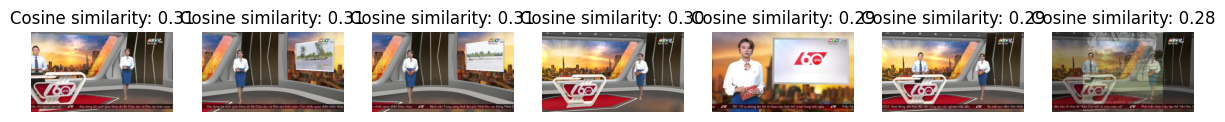

In [25]:
import matplotlib.pyplot as plt
from PIL import Image

query_text = "A female MC is in the studio and standing next to the projection screen, the projection screen is displaying a logo that looks like the number 60"
fuse_feature=get_feature(query_text=query_text)
fuse_feature = fuse_feature.cpu().detach().numpy()
k = 7  # Số lượng keyframe trả về
D, I = index.search(fuse_feature, k)

print(query_text)
fig, axes = plt.subplots(1, k, figsize=(15, 10))

for i in range(k):
    keyframe_path = image_files[I[0, i]]
    print(f"Keyframe: {keyframe_path}, Cosine similarity: {D[0, i]}")

    image = Image.open(keyframe_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Cosine similarity: {D[0, i]:.2f}")
    axes[i].axis('off')

plt.show()

